# Do Batch Processing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

/home/alex/NuMI/PELEE/


## BNB Sample Histograms - Nue Nue

In [2]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
#full sample
NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune

#actually fetch datasets
nue_nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_nue]

nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'nmuon']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)

['shr_distance', 'shr_energy_tot_cali', 'selected', 'nslice', 'contained_fraction', 'shr_tkfit_nhits_U', 'slnhits', 'shr_tkfit_dedx_V', 'trkshrhitdist2', 'nproton', 'ccnc', 'run', 'n_tracks', 'tksh_angle', 'reco_nu_vtx_sce_y', 'CosmicIPAll3D', 'shr_score', 'category', 'shr_tkfit_dedx_Y', 'trk_energy', 'evt', 'n_showers_contained', 'shr_tkfit_nhits_V', 'reco_nu_vtx_sce_z', 'trk_energy_tot', 'shr_tkfit_nhits_Y', 'sub', 'shr_phi', 'shr_energy', 'topological_score', 'nu_pdg', 'shrsubclusters2', 'shr_theta', 'hits_ratio', 'slnunhits', 'shrsubclusters0', 'nmuon', 'trk_score_v', 'shrmoliereavg', 'n_tracks_contained', 'n_showers', 'shr_tkfit_dedx_U', 'reco_nu_vtx_sce_x', 'shrsubclusters1', 'npion', 'shr_tkfit_npoints', 'tksh_distance', 'flash_time', 'shr_energy_cali']


In [3]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_nue]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']
    #print(df['mc_pdg'])

In [4]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_nue]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    

In [5]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [6]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [7]:
#These two are the same

#print(df["elec_vx"])
#print(df["true_nu_vtx_x"])

In [8]:
for i,df in enumerate(df_v):
    df["elec_px_asmuon"] = np.nan
    df["elec_py_asmuon"] = np.nan
    df["elec_pz_asmuon"] = np.nan
    for j in range(len(df["mc_pdg"])):
        pdg_vector = df["mc_pdg"].iloc[j][0]
        px_vector = df["mc_px"].iloc[j]
        py_vector = df["mc_py"].iloc[j]
        pz_vector = df["mc_pz"].iloc[j]
        result = np.where(pdg_vector==11)[0]
        if np.size(result):
            df.loc[j, "elec_px_asmuon"] = px_vector[result][0]
            df.loc[j, "elec_py_asmuon"] = py_vector[result][0]
            df.loc[j, "elec_pz_asmuon"] = pz_vector[result][0]
            
    print(df["elec_px_asmuon"])

entry
0              NaN
1         1.504711
2        -0.197600
3         0.142221
4         0.128535
            ...   
127546    0.195821
127547    2.786030
127548    1.216194
127549         NaN
127550    0.975678
Name: elec_px_asmuon, Length: 127551, dtype: float64


In [9]:
for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'] + df['elec_pz_asmuon']*df['elec_pz_asmuon'])
    df['targetPt_asmuon']    = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'])
    df['targetTheta_asmuon'] = np.arccos(df['elec_pz_asmuon']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['elec_py_asmuon'],df['elec_px_asmuon'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [7]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_nue]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  10.806354522705078


In [9]:
#Electron Angle

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'] + df['elec_pz_asmuon']*df['elec_pz_asmuon'])
    df['targetPt_asmuon']    = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'])
    df['targetTheta_asmuon'] = np.arccos(df['elec_pz_asmuon']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['elec_py_asmuon'],df['elec_px_asmuon'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

KeyError: 'elec_px_asmuon'

In [8]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [9]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
    

In [10]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_nue]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
#    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
#    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])


In [11]:
# add back the cosmic category, for background only
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
    

In [12]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_nue]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [13]:
#Define signal catagories

#nue_nue["is_signal"] = nue_nue["category"] == 11

In [14]:
# Some quick clean up since some strange events get in there
nue_nue   = nue_nue.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_nue]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

In [15]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

In [16]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [17]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [18]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_nue]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(127551, 117)


In [19]:
datasets_bdt = nue_nue

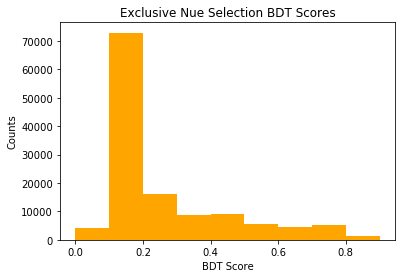

In [20]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [21]:
for i,df in enumerate(df_v):

    df['is_signal'] = np.where((df.nu_e>0.04) & (df.nu_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==11)
                             & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0)
                             & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
                             & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
                             & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
 

In [22]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'
NUE_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'
NUE_SEL_QUERY += ' and nu_e > 0.04 and nu_e < 5'

SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
NOT_SIGNAL_NUE_SEL_QUERY += 'and is_signal==False'

In [23]:


truthsel_nue  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
truthsel_nue  += " and category == 11"
truthsel_nue += ' and reco_e > 0.04 and reco_e < 5'

truthsel_nue_simple  = "nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nu_e > 0.04 and nu_e < 5"
truthsel_nue_simple  += " and category == 11"
truthsel_nue_simple += ' and reco_e > 0.04 and reco_e < 5'


##note muonnnn added? and nmuon > 0
truthsel_numu  = "(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
truthsel_numu  += " and category == 2"


n_events here =  127551
n_events/2 here =  25510.0

1.0
1
0
127551
{'nue_nue': 0.008409085175623745}
is_signal==True& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_nue
[1.2228513  0.5187539  0.42641643 ... 1.1436439  0.8197148  0.56377584]
TEST
1
2
3
current_total  320.6003014235392
320.600301423539178813371108844876289367675781250000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  320.6003014235392
320.600301423539178813371108844876289367675781250000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  320.6003014235392
320.600301423539178813371108844876289367675781250000000000000000000000000000000
current_total_split  [320.6003014235392]
---------------------------STILL TOGETHER HERE (PAST PLOTTING)--------------------------------

-------------------NOT GOOD BY HERE------------------
current_to

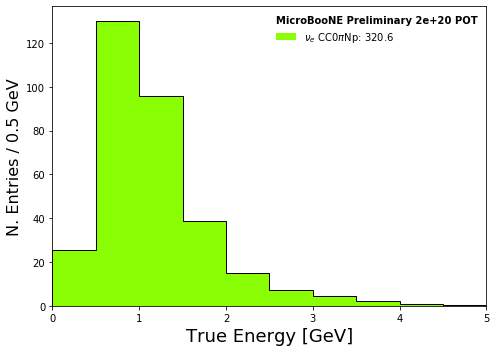

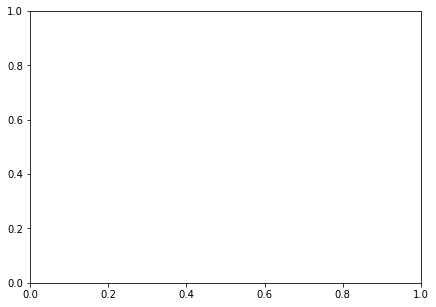

In [31]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/5))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size                     #do this for fist 50

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size   #this is i in standard
    print(start)
    #print(end)
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    print(sample_set.shape[0])
    
    samples = {
        #"nue_nue": nue_nue
        "nue_nue": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    nueratio  = pot/2.37838e+22 

    # NUE
    weights = { #full sample mc = 0.38
                "nue_nue"  : nueratio  * SPLIT * scaling
                #"nue_nue"  : 1
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]" 
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1.0, 1.0),"cos(Electron Angle)"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        #query= SIGNAL_NUE_SEL_QUERY,
        query = "is_signal==True",
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)
    

No handles with labels found to put in legend.


320.60030142353946
0.0


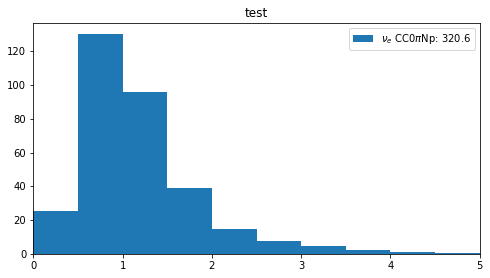

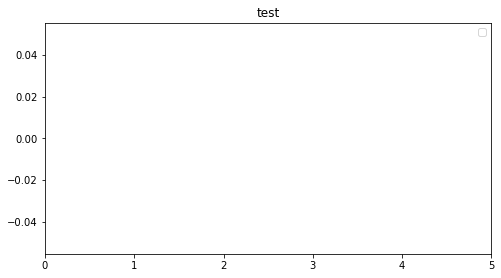

In [25]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("test")
    plt.legend()

    print(sum(nue_stacked[0]))

In [26]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

7.294178111863872437936606729635968804359436035156250000000000000000000000000
[ 25.54917281 130.21068376  95.89263236  38.90477975  14.75874474
   7.29417811   4.35415659   2.19412388   1.04933144   0.39249798]


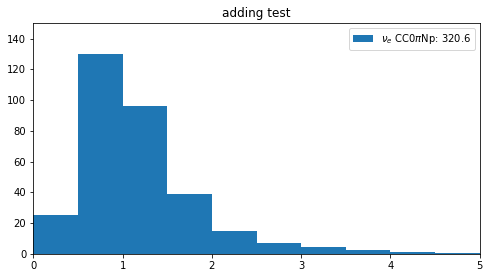

In [27]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
nue_ax1.set_xlim([0.0, 5.0])
nue_ax1.set_ylim([0,150])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 180])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

print('%.75f' % nue_stacked[0][5])
print(nue_stacked[0])

In [28]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 0

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [29]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)


######full trueE
#vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_trueE.csv')
#weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_trueE.csv')
vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_trueE_recoCut_07Jul.csv')
weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_trueE_recoCut_07Jul.csv')
#######angleElec
#vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleElec.csv')
#weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleElec.csv')
########angleDiff
#vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff.csv')
#weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff.csv')
########leptonMom
#vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom.csv')
#weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom.csv')

### Stat Errors

In [33]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1.0, 1.0),"cos(Electron Angle)"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        detsys=True,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  127551

3.188775
3
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_nue

LOOK HERE FOR SETSYS
True


TypeError: argument of type 'bool' is not iterable

In [47]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

nue_nue_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_nue_stat_errs_selected = total_sels

total errs =  [1.1065832534190165, 1.0436489384121197, 0.3950719302736305, 0.1551436933990237, 0.06519712183860521, 0.03768987629064705, 0.0185267309346145, 0.009263365467307248, 0.0028992212531266963, 0.0006364144214180552]
total selected =  [143.14598941802979, 139.45010662078857, 52.25207591056824, 19.194140076637268, 8.095365285873413, 4.770997554063797, 2.3325719833374023, 1.1975739523768425, 0.36728246696293354, 0.07955179736018181]


In [48]:
"""
np.savetxt("nue_nue_stat_errs_full_catsel_nopions_trueE.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_trueE.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

"""
#########################
#####angleElec###########
##########################
"""
np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleElec.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleElec.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""

#########################
#####angleDiff###########
##########################
"""
np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleDiff.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleDiff.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""


#########################
#####leptonMom###########
##########################

np.savetxt("nue_nue_stat_errs_full_catsel_nopions_leptonMom.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_leptonMom.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')


### Sys Errors - nue nue

In [49]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1.0, 1.0),"cos(Electron Angle)"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsPPFX",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)

n_events here =  127551

3.188775
3
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'nue_nue': 0.008409085175623745}
(nu_pdg ==

In [50]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_nue_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [51]:
"""
np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_trueE.csv", 
           final_ns_nue_nue_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_trueE.csv", 
           final_ncvs_nue_nue_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_trueE.csv')
total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_trueE.csv')
total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_trueE.csv')
"""

#################################
#####angleElec##################
############################
"""
np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_angleElec.csv", 
           final_ns_nue_nue_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleElec.csv", 
           final_ncvs_nue_nue_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_angleElec.csv')
total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_angleElec.csv')
total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_angleElec.csv')
"""
"""
#################################
#####angleDiff##################
############################

np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff.csv", 
           final_ns_nue_nue_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff.csv", 
           final_ncvs_nue_nue_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_angleDiff.csv')
total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff.csv')
total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff.csv')
"""

#################################
#####leptonMom##################
############################

np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom.csv", 
           final_ns_nue_nue_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom.csv", 
           final_ncvs_nue_nue_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_leptonMom.csv')
total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom.csv')
total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom.csv')


In [52]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1.0, 1.0),"cos(Electron Angle)"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline  = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsGenie",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)

n_events here =  127551

3.188775
3
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'nue_nue': 0.008409085175623745}
(nu_pdg ==

In [53]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_genie.append(sum(masterlist[a]))

final_ncvs_nue_nue_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


entry
1         0.008409
3         0.008409
4         0.008409
9         0.008409
11        0.008409
12        0.008409
19        0.008409
21        0.008409
24        0.008409
27        0.008409
31        0.008409
32        0.008409
33        0.008409
38        0.008409
46        0.008409
50        0.008409
52        0.008409
55        0.008409
60        0.008409
73        0.008409
74        0.008409
76        0.008409
77        0.008409
80        0.008409
84        0.008409
89        0.008409
91        0.008409
92        0.008409
94        0.008409
96        0.008409
102       0.008409
103       0.008409
111       0.008409
115       0.008409
116       0.008409
118       0.008409
119       0.008409
122       0.008409
127       0.008409
132       0.008409
140       0.008409
141       0.008409
142       0.008409
143       0.008409
144       0.008409
145       0.008409
149       0.008409
154       0.008409
155       0.008409
170       0.008409
173       0.008409
175       0.008409
178   

In [54]:
"""
np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_trueE.csv", 
           final_ns_nue_nue_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_trueE.csv", 
           final_ncvs_nue_nue_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_trueE.csv')
total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_trueE.csv')
total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_trueE.csv')
"""
"""
#####################
###AngleElec###
######################
np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_angleElec.csv", 
           final_ns_nue_nue_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_angleElec.csv", 
           final_ncvs_nue_nue_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_angleElec.csv')
total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_angleElec.csv')
total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_angleElec.csv')
"""

"""
#####################
###AngleDiff###
######################
np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff.csv", 
           final_ns_nue_nue_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff.csv", 
           final_ncvs_nue_nue_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_angleDiff.csv')
total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff.csv')
total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff.csv')
"""

#####################
###leptonMom###
######################
np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom.csv", 
           final_ns_nue_nue_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom.csv", 
           final_ncvs_nue_nue_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_leptonMom.csv')
total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom.csv')
total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom.csv')


In [55]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("weightsReint")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1.0, 1.0),"cos(Electron Angle)"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsReint",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)

n_events here =  127551
weightsReint
1.0
1
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------



In [56]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_reint.append(sum(masterlist[a]))

final_ncvs_nue_nue_reint = sum(n_cv_tots)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)


entry
1         1.028306e-02
3         4.362246e-03
4         3.585772e-03
9         5.156332e-03
11        1.054614e-02
12        7.265935e-03
19        1.203750e-02
21        1.810025e-06
24        8.660679e-03
27        9.988010e-03
31        1.047277e-02
32        1.221035e-07
33        9.669649e-03
38        1.110938e-02
46        8.765284e-03
50        1.302625e-02
52        9.154076e-03
55        4.941175e-03
60        1.236394e-02
73        9.284939e-03
74        5.246030e-03
76        7.665547e-03
77        8.656179e-02
80        9.385142e-03
84        1.100124e-02
89        1.050955e-05
91        7.277783e-03
92        9.783473e-03
94        4.653982e-03
96        1.066682e-02
102       5.223181e-03
103       9.563383e-03
111       7.818695e-03
115       1.309974e-02
116       8.521276e-03
118       1.072965e-02
119       9.036594e-03
122       9.863263e-03
127       7.970267e-03
132       9.879494e-03
140       9.728088e-03
141       1.094094e-02
142       5.990098e-02
143  

In [57]:
"""
np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_trueE.csv", 
           final_ns_nue_nue_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_trueE.csv", 
           final_ncvs_nue_nue_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_trueE.csv')
total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_trueE.csv')
total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_trueE.csv')
"""
"""
#################
###angleElec#####
#################

np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_angleElec.csv", 
           final_ns_nue_nue_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_angleElec.csv", 
           final_ncvs_nue_nue_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_angleElec.csv')
total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_angleElec.csv')
total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_angleElec.csv')
"""

"""
#################
###angleDiff#####
#################

np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff.csv", 
           final_ns_nue_nue_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff.csv", 
           final_ncvs_nue_nue_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_angleDiff.csv')
total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff.csv')
total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff.csv')
"""


#################
###leptonMom#####
#################

np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom.csv", 
           final_ns_nue_nue_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom.csv", 
           final_ncvs_nue_nue_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_leptonMom.csv')
total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom.csv')
total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom.csv')


In [58]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
batch_size = 20000

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1.0, 1.0),"cos(Electron Angle)"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_nue",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)

n_events here =  127551
6.37755
7
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& targetP_asmuon <= 5 & targetP_asmuon >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_

In [59]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_geo.append(sum(masterlist[a]))

final_ncvs_nue_nue_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_nue_nue_geo)):
    final_ns_nue_nue_geo[x] = np.concatenate((final_ns_nue_nue_geo[x][0], final_ns_nue_nue_geo[x][1]))
    
    
#print(final_ns_nue_nue_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

'\n#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...\nmasterlist = []\ntemplist = []\nfor i in range((len(n_tots))):\n    masterlist.append(templist)\n    templist = []\n    for j in range(len(n_tots[0])):\n        templist.append(errs[j][i])\nmasterlist.append(templist)\n    \nmasterlist.pop(0)\n\n\n#deal with adding the errors in each bin\ntotal_errs = []\nholdlist = []\nfor f in masterlist:\n    total_errs.append(sum(holdlist))\n    #print("------------------------------")\n    holdlist = []\n    for g in f:\n        #just add them as they differnt parts of the same total number. This then matches previous when doing total\n        holdlist.append(g)\ntotal_errs.append(sum(holdlist))\n\ntotal_errs.pop(0)\nprint("total errs = ", total_errs)\n\nnue_nue_stat_errs = total_errs\n\n\n\n\nvariationNumber=0\n\n#need to add 7 together to make a batch? sum? - over batch, not varation\n\nfor n_tot in n_tots:\n    for n_tot_pair in n_tot:\n   

In [60]:
"""
np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_trueE.csv", 
           final_ns_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_trueE.csv", 
           final_ncvs_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_trueE.csv')
total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_trueE.csv')
total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_trueE.csv')
"""
"""
#####################
###angleElec########
####################

np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_angleElec.csv", 
           final_ns_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_angleElec.csv", 
           final_ncvs_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_angleElec.csv')
total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_angleElec.csv')
total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_angleElec.csv')
"""

"""
#####################
###angleDiff########
####################

np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_angleDiff.csv", 
           final_ns_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff.csv", 
           final_ncvs_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_angleDiff.csv')
total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_angleDiff.csv')
total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_angleDiff.csv')
"""

#####################
###leptonMom########
####################

np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_leptonMom.csv", 
           final_ns_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom.csv", 
           final_ncvs_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_leptonMom.csv')
total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_leptonMom.csv')
total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_leptonMom.csv')


## Nue_Mc

Unneeded for truth.

## Nue_Dirt

Unneeded for truth.

## Now for Numu

## Numu_Mc

In [2]:
tree = "NeutrinoSelectionFilter"

#presamp
#NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND
#full
NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune

numu_mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]


uproot_v = [numu_mc] 


numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon",
        "reco_e", "shr_energy_tot_cali", "trk_energy_tot",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]

numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique
numu_variables = list(set(numu_variables))
print(numu_variables)


    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['true_e_visible', 'npion', 'CosmicIP', 'trk_mcs_muon_mom_v', 'pi0_e', 'trk_energy_tot', 'run', 'trk_range_muon_mom_v', 'evt', 'CosmicIPAll3D', 'trk_llr_pid_score_v', 'trk_energy_muon', 'ccnc', 'backtracked_pdg', 'category', 'trk_theta', 'mc_pdg', 'slclustfrac', 'reco_e', 'nproton', 'trk_sce_end_z_v', 'CosmicDirAll3D', '_opfilter_pe_veto', 'shr_energy_tot_cali', 'npi0', 'evnunhits', 'trk_phi', '_opfilter_pe_beam', 'reco_nu_vtx_sce_y', 'slnunhits', 'nu_pdg', 'slpdg', 'interaction', 'trk_sce_end_x_v', 'reco_nu_vtx_sce_z', 'reco_nu_vtx_sce_x', 'isVtxInFiducial', 'nslice', 'reco_nu_vtx_z', 'sub', 'nmuon', 'flash_pe', 'pion_e', 'muon_e', 'trk_sce_start_x_v', 'pi0truth_elec_etot', 'trk_sce_end_y_v', 'reco_nu_vtx_y', 'topological_score', 'reco_nu_vtx_x', 'slnhits']


In [3]:
import time
s = time.time()

import pandas as pandas

mc_var   = numu_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX + numu_varMC

# This needs modifications (add variables from above)
uproot_v = [numu_mc] 
var_v    = [mc_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_mc = CVDF

s2 = time.time()

print("runtime = ", s2-s)

trk_llr_pid_v  [[0.73482436] [-0.70503384 0.5525445 -3.4028235e+38] [] ... [] [] [0.9896643 0.5211012 0.04211452]]
trk_score_v  [[0.8417371] [0.9219987 0.9697223 -1.0] [] ... [] [] [1.0 0.011713999 0.47363594]]
Here:
trk_range_muon_mom_v  [[0.2488809] [0.121225685 0.109380074 -3.4028235e+38] [] ... [] [] [1.2258223 0.20158982 0.05128334]]
trk_mcs_muon_mom_v  [[0.27999988] [0.40099838 14.999432 -3.4028235e+38] [] ... [] [] [1.9420298 0.13100009 14.993429]]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


runtime =  1480.518544435501


In [6]:
#numu_mc   = numu_mc.query('(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
# 254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2', inplace=True)
numu_mc.query('nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5 and category == 2', inplace=True)

In [7]:
df_v = [numu_mc]
#print(df_v)
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [8]:
s = time.time()

df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
     # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    
    
s2 = time.time()
print("runtime = ", s2-s)

runtime =  425.359179019928


In [9]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']

In [10]:
df_v = [numu_mc]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ]

In [11]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [12]:
df_v = [numu_mc]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [13]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_5202/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  13.936066627502441


In [14]:
#numu_mc["is_signal"]   = numu_mc["category"] == 2
#print(numu_mc["is_signal"])

In [15]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [16]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [19]:
s = time.time()

for i,df in enumerate(df_v):
    df["muon_px"] = df["ccnc"].copy()
    df["muon_py"] = df["ccnc"].copy()
    df["muon_pz"] = df["ccnc"].copy()
    for j, row in df.iterrows():
        pdg_vector = df["mc_pdg"].loc[j][0]
        px_vector = df["mc_px"].loc[j]
        py_vector = df["mc_py"].loc[j]
        pz_vector = df["mc_pz"].loc[j]
        result = np.where(pdg_vector==13)[0]
        if np.size(result):
            df.loc[j, "muon_px"] = px_vector[result][0]
            df.loc[j, "muon_py"] = py_vector[result][0]
            df.loc[j, "muon_pz"] = pz_vector[result][0]   
            
    print(df["muon_px"])

print("")    
print("==========================")
s2 = time.time()
print("runetime = ", s2-s)

entry
0         0.266320
1         0.207083
24        0.997299
43        0.068607
61        0.549061
67        0.414639
115       1.015078
118       0.478537
144       0.768518
162       0.774016
172       2.537876
174      -0.223374
190       0.494987
212       0.947628
215       0.091346
281       0.993013
285       0.879058
296      -0.037077
302       0.007184
303       1.483034
307      -0.199967
311       0.741184
317       0.563060
326      -0.003930
341       0.143531
351       0.320269
356       0.449909
360      -0.117775
364       0.303781
379      -0.078191
394       0.004071
399      -0.166722
406       0.225324
411       0.172171
414       0.386737
455       0.071879
460       0.026125
461      -0.099933
472       1.408762
477       0.304633
504       0.199561
505       0.014084
518      -0.155054
527      -0.150616
540       0.584836
542      -0.235520
552      -0.077378
571       0.250792
589       0.099865
599       0.011486
608       0.521175
610       0.833535
621   

In [21]:
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta'],x['targetPhi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])

In [17]:
numu_mc   = numu_mc.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
df_v = [numu_mc]
for i,df in enumerate(df_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

In [18]:
for i,df in enumerate(df_v):

    df['is_signal'] = np.where((df.nu_e>0.04) & (df.nu_e <5) & (df.reco_e>0.04) & (df.reco_e <5) & (df.category==2)
                             & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0)
                             & (-1.55 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 254.8)
                             & (-116.5 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 116.5)
                             & (0 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1036.8), True, False)
   

In [19]:
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)\
and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 \
and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 \
and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_pions_tot == 0"
NUMU_SEL_QUERY += ' and reco_e > 0.04 and reco_e < 5'

SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
NOT_SIGNAL_NUMU_SEL_QUERY += 'and is_signal==False'

In [23]:
#print(df['weightsNuMIGeo'][0])

##truthsel_nue  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 #254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
#truthsel_nue  += " and category == 11"

truthsel_numu  = "(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
truthsel_numu  += " and category == 2"
truthsel_numu += ' and reco_e > 0.04 and reco_e < 5'

n_events here =  74198

1.0
1
{'numu_mc': 0.08559738414394057}
is_signal==True& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
TEST
1
2
3
current_total  6704.451479125042
6704.451479125042169471271336078643798828125000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  6704.451479125042
6704.451479125042169471271336078643798828125000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  6704.451479125042
6704.451479125042169471271336078643798828125000000000000000000000000000000000000
current_total_split  [6704.451479125042]
---------------------------STILL TOGETHER HERE (PAST PLOTTING)--------------------------------

-------------------NOT GOOD BY HERE------------------
current_total_hist  [1011.16888403 2086.34697773 1662.74372383 1079.4921212   449.42161264
  181.00842877  108.45917309   64.00839843   38.669541

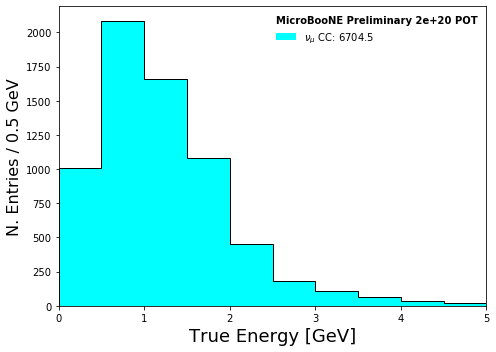

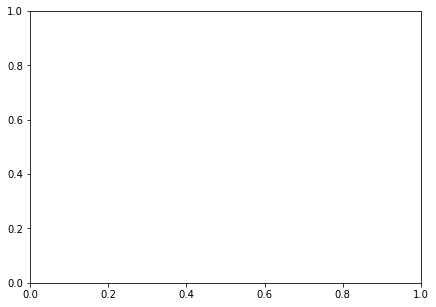

In [26]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    mcratio   = pot/2.33652e+21

    
    weights = { #full sample mc = 0.38
                "numu_mc": mcratio  * SPLIT * scaling,
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)

    #Now check on a variable
    #Remember to change the plotter keys between truth and mc

    VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1, 1),"cos(Muon Angle)"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        #query= truthsel_numu,
        query= "is_signal==True",
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    print(len(varss))
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


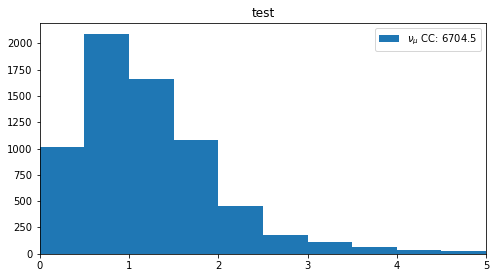

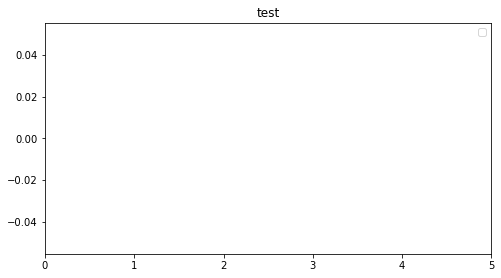

In [27]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])   #trueE, leptonMom
    #nue_ax1.set_xlim([-1, 1])   #angleMuon

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("test")
    plt.legend()

In [28]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

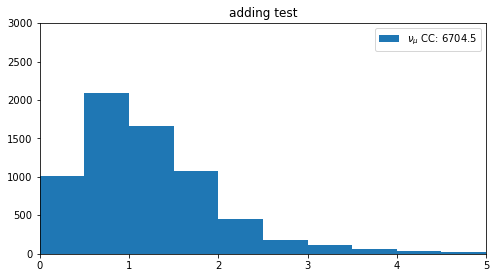

In [29]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$",
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}

labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#Nu Energy, leptonMom
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 3000])
#angleMuon
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 300])
#angleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 3600])


nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [30]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

wanted_key = 4

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)


[]

SUMS
[]
[]

Wanted List:
[]



In [31]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

#full
#vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_trueE.csv')
#weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_trueE.csv')
vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_trueE_recoCut_07Jul.csv')
weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_trueE_recoCut_07Jul.csv')
#angleMuon
#vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_angleMuon.csv')
#weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_angleMuon.csv')
#angleDiff
#vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_angleDiff.csv')
#weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_angleDiff.csv')
#leptonMom
#vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_leptonMom.csv')
#weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_leptonMom.csv')

### Stat Errors

In [34]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21 

    
    weights = {
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Muon Angle)"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  74198

1.85495
1
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& targetP <= 5 & targetP >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  numu_mc

err numu mc: 
[119.63382195  82.12003163  50.26994441  22.03935181   8.82892917
   5.15814617   2.61570765   1.37745949   0.8425949    0.19049972]
detsys numu mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [1517.6393    1063.1117     649.7249     269.21628    106.44737
   64.27718     32.56766     17.855404    10.840436     2.5261405]
Returning
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.

In [35]:
#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errors = ", total_errs)

numu_mc_stat_errs = total_errs

#########################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

numu_mc_stat_errs_selected = total_sels

total errors =  [221.44126658297944, 153.22771425900305, 92.5389007359637, 41.20655405693269, 16.698032840638263, 9.15864021535666, 4.92368497977574, 2.7182844159178563, 1.3921133127342125, 0.3370379599251251]
total selected =  [2800.9298095703125, 1986.8670043945312, 1190.0214233398438, 506.1981506347656, 200.68260955810547, 112.96740341186523, 61.382408142089844, 35.510759353637695, 17.545517921447754, 4.367492437362671]


In [36]:
"""
np.savetxt("numu_mc_stat_errs_full_catsel_nopions_trueE.csv", 
           numu_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_trueE.csv", 
           numu_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""
"""
############################
#####angleMuon#############
#############################

np.savetxt("numu_mc_stat_errs_full_catsel_nopions_angleMuon.csv", 
           numu_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_angleMuon.csv", 
           numu_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""
"""
############################
#####angleDiff#############
#############################

np.savetxt("numu_mc_stat_errs_full_catsel_nopions_angleDiff.csv", 
           numu_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_angleDiff.csv", 
           numu_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""

############################
#####leptonMom#############
#############################

np.savetxt("numu_mc_stat_errs_full_catsel_nopions_leptonMom.csv", 
           numu_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_leptonMom.csv", 
           numu_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')


## Sys errs - numu mc

In [37]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Muon Angle)"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline  = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsPPFX",
        #category_query = " and category == 2",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)

n_events here =  74198

1.85495
1
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& targetP <= 5 & targetP >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& targetP <= 5 & targetP >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------



In [38]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_ppfx.append(sum(masterlist[a]))


final_ncvs_numu_mc_ppfx = sum(n_cv_tots)


#------------------------
frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [39]:
"""
np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_trueE.csv", 
           final_ns_numu_mc_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_trueE.csv", 
           final_ncvs_numu_mc_ppfx,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_trueE.csv')
total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_trueE.csv')
total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_trueE.csv')
"""
###############################
######angleMuon##########
######################
"""
np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleMuon.csv", 
           final_ns_numu_mc_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleMuon.csv", 
           final_ncvs_numu_mc_ppfx,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_angleMuon.csv')
total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleMuon.csv')
total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleMuon.csv')
"""
"""
###############################
######angleDiff##########
######################

np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff.csv", 
           final_ns_numu_mc_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff.csv", 
           final_ncvs_numu_mc_ppfx,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_angleDiff.csv')
total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff.csv')
total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff.csv')
"""

###############################
######leptonMom##########
######################

np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom.csv", 
           final_ns_numu_mc_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom.csv", 
           final_ncvs_numu_mc_ppfx,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom.csv')
total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom.csv')
total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom.csv')


In [40]:
#############################
##### weightsgenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(EMuon Angle)"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsGenie",
        #category_query = " and category == 2",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)

n_events here =  74198

1.85495
1
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& targetP <= 5 & targetP >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& targetP <= 5 & targetP >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------



In [41]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_genie.append(sum(masterlist[a]))

final_ncvs_numu_mc_genie = sum(n_cv_tots)

##################################################

frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [42]:
"""
np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_trueE.csv", 
           final_ns_numu_mc_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_trueE.csv", 
           final_ncvs_numu_mc_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_trueE.csv')
total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_trueE.csv')
total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_trueE.csv')
"""
###########################
#####angleMuon###########
##########################
"""
p.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleMuon.csv", 
           final_ns_numu_mc_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleMuon.csv", 
           final_ncvs_numu_mc_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_angleMuon.csv')
total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleMuon.csv')
total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleMuon.csv')
"""
"""
###########################
#####angleDiff###########
##########################

np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff.csv", 
           final_ns_numu_mc_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff.csv", 
           final_ncvs_numu_mc_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_angleDiff.csv')
total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff.csv')
total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff.csv')
"""

###########################
#####leptonMom###########
##########################

np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom.csv", 
           final_ns_numu_mc_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom.csv", 
           final_ncvs_numu_mc_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom.csv')
total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom.csv')
total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom.csv')


In [43]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Muon Angle)"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsReint",
        #category_query = " and category == 2",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)

n_events here =  74198

1.85495
1
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& targetP <= 5 & targetP >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& targetP <= 5 & targetP >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------



In [44]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_reint.append(sum(masterlist[a]))

final_ncvs_numu_mc_reint = sum(n_cv_tots)

###################################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
    
    
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)

In [45]:
"""
np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_trueE.csv", 
           final_ns_numu_mc_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_trueE.csv", 
           final_ncvs_numu_mc_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_trueE.csv')
total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_trueE.csv')
total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_trueE.csv')
"""
#############################
#####angleMuon##########
#######################
"""
np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleMuon.csv", 
           final_ns_numu_mc_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleMuon.csv", 
           final_ncvs_numu_mc_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_angleMuon.csv')
total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleMuon.csv')
total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleMuon.csv')
"""
"""
#############################
#####angleDiff##########
#######################

np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff.csv", 
           final_ns_numu_mc_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff.csv", 
           final_ncvs_numu_mc_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_angleDiff.csv')
total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff.csv')
total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff.csv')
"""

#############################
#####leptonMom##########
#######################

np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom.csv", 
           final_ns_numu_mc_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom.csv", 
           final_ncvs_numu_mc_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom.csv')
total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom.csv')
total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom.csv')


In [46]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Muon Angle)"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP',10,(0.0, 5.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_mc",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        #category_query = " and category == 2",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)

n_events here =  74198
1.85495
2
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& targetP <= 5 & targetP >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& targetP <= 5 & targetP >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------



In [47]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_mc_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_geo.append(sum(masterlist[a]))

final_ncvs_numu_mc_geo = sum(n_cv_tots)
    
for x in range(len(final_ns_numu_mc_geo)):
    final_ns_numu_mc_geo[x] = np.concatenate((final_ns_numu_mc_geo[x][0], final_ns_numu_mc_geo[x][1]))
    
#############################################################
frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [48]:
"""
np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_trueE.csv", 
           final_ns_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_trueE.csv", 
           final_ncvs_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_trueE.csv')
total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_trueE.csv')
total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_trueE.csv')
"""
########################
####angleMuon##########
#######################

"""
np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_angleMuon.csv", 
           final_ns_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleMuon.csv", 
           final_ncvs_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_angleMuon.csv')
total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_angleMuon.csv')
total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_angleMuon.csv')
"""
########################
####angleDiff##########
#######################
"""

np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_angleDiff.csv", 
           final_ns_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff.csv", 
           final_ncvs_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_angleDiff.csv')
total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_angleDiff.csv')
total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_angleDiff.csv')
"""

########################
####leptonMom##########
#######################


np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom.csv", 
           final_ns_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom.csv", 
           final_ncvs_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_leptonMom.csv')
total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom.csv')
total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom.csv')

## Numu_Dirt

Unneeded for truth.